# This script processes the tfm results of the minRadius stude

1. Compile parallelcpp with:
```
make bin/parallelcpp
```
2. Run the benchmarking script
```
cd scripts
python3 run_par_minradius
```
3. The output that we will process is parallelcpp_maxnum_coffee.txt (renamed from parallelcpp.out)



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize(filename):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                name=tokens[2].split("/")[3]
                nth=int(tokens[6])
                maxNum = int(tokens[9])
                if name not in experiment:
                    experiment[name]={}
                if maxNum not in experiment[name]:
                    experiment[name][maxNum]={}
            if 'Quadtree' in tokens:
                experiment[name][maxNum][nth]=[float(tokens[5])]
            if "STAGE" in tokens:
                experiment[name][maxNum][nth].append(float(tokens[5]))
            if 'Average:' in tokens:
                experiment[name][maxNum][nth].append(float(tokens[1]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={} #LiDAR cloud name
        for j in experiment[i]:
            results[i][j]={} #minRad
            for k in experiment[i][j]:
                results[i][j][k]={} #nth
                results[i][j][k]['qtree']=experiment[i][j][k][0]
                results[i][j][k]['stage1']=mean(experiment[i][j][k][1:16:3])
                results[i][j][k]['stage2']=mean(experiment[i][j][k][2:16:3])
                results[i][j][k]['stage3']=mean(experiment[i][j][k][3:16:3])
                results[i][j][k]['owm']=experiment[i][j][k][16]
    return results

res1=tokenize("parallelcpp_maxnum_coffe.txt")

#print(results)



In [7]:
for i in res1:
    times=[res1[i][j][1]['owm'] for j in res1[i]]
    mintime=min(times)
    maxNum=np.argmin(times)
    print("Cloud {} wint maxNumber {:.1f} has sequential OWM best time = {:.2f}".format(i,list(res1[i].keys())[maxNum],mintime ))


Cloud Alcoy wint maxNumber 512.0 has sequential OWM best time = 3.60
Cloud Arzua wint maxNumber 512.0 has sequential OWM best time = 2.78
Cloud BrionF wint maxNumber 128.0 has sequential OWM best time = 1.99
Cloud BrionU wint maxNumber 128.0 has sequential OWM best time = 2.27


In [8]:
for i in res1:
    times=[res1[i][j][8]['owm'] for j in res1[i]]
    mintime=min(times)
    naxNum=np.argmin(times)
    print("Cloud {} wint maxNumber {:.1f} has 8-core OWM best time = {:.2f}".format(i,list(res1[i].keys())[naxNum],mintime ))


Cloud Alcoy wint maxNumber 512.0 has 8-core OWM best time = 0.68
Cloud Arzua wint maxNumber 512.0 has 8-core OWM best time = 0.55
Cloud BrionF wint maxNumber 64.0 has 8-core OWM best time = 1.34
Cloud BrionU wint maxNumber 64.0 has 8-core OWM best time = 1.54


In [9]:
for i in res1:
    times=[res1[i][j][1]['qtree'] for j in res1[i]]
    mintime=min(times)
    maxNum=np.argmin(times)
    print("Cloud {} wint maxNumber {:.1f} has qtree creation best time = {:.2f}".format(i,list(res1[i].keys())[maxNum],mintime ))


Cloud Alcoy wint maxNumber 32768.0 has qtree creation best time = 1.72
Cloud Arzua wint maxNumber 65536.0 has qtree creation best time = 2.07
Cloud BrionF wint maxNumber 32768.0 has qtree creation best time = 2.19
Cloud BrionU wint maxNumber 32768.0 has qtree creation best time = 2.69


In [10]:
for i in res1:
    times=[res1[i][j][1]['qtree']+res1[i][j][8]['owm'] for j in res1[i]] #8-core OWM + qtree times
    mintime=min(times)
    maxNum=np.argmin(times)
    print("Cloud {} wint maxNumber {:.1f} has total (8-core owm + qtree creation) best time = {:.2f}".format(i,list(res1[i].keys())[maxNum],mintime ))


Cloud Alcoy wint maxNumber 2048.0 has total (8-core owm + qtree creation) best time = 2.55
Cloud Arzua wint maxNumber 8192.0 has total (8-core owm + qtree creation) best time = 2.98
Cloud BrionF wint maxNumber 1024.0 has total (8-core owm + qtree creation) best time = 4.46
Cloud BrionU wint maxNumber 1024.0 has total (8-core owm + qtree creation) best time = 5.08


# Execution time for each cloud with tfm/parallelcpp version depending on minRadius

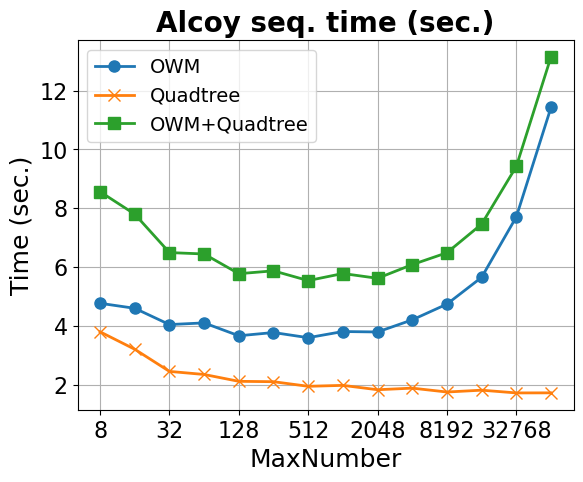

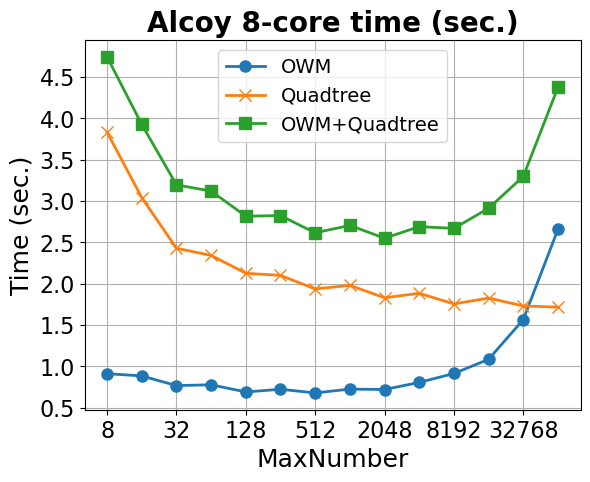

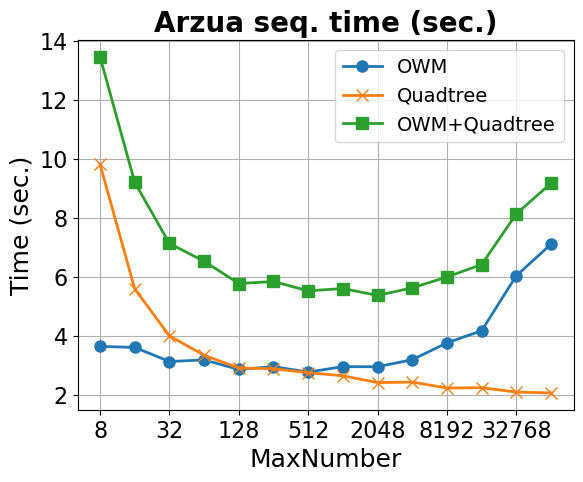

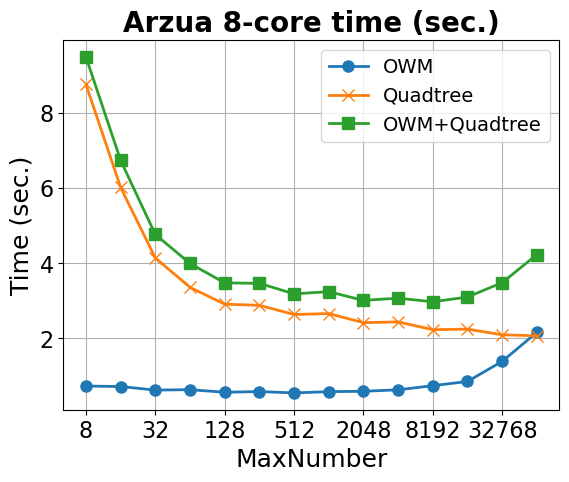

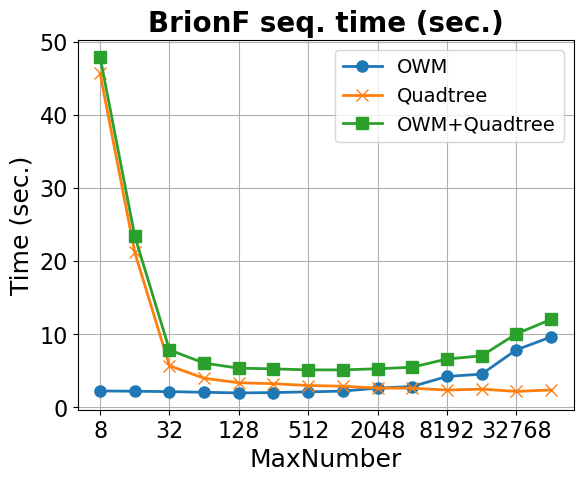

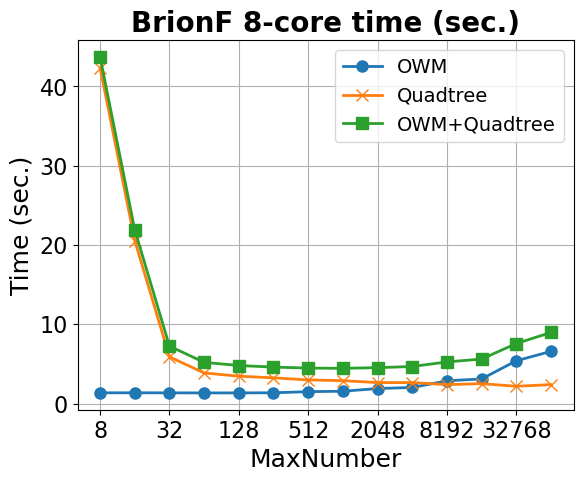

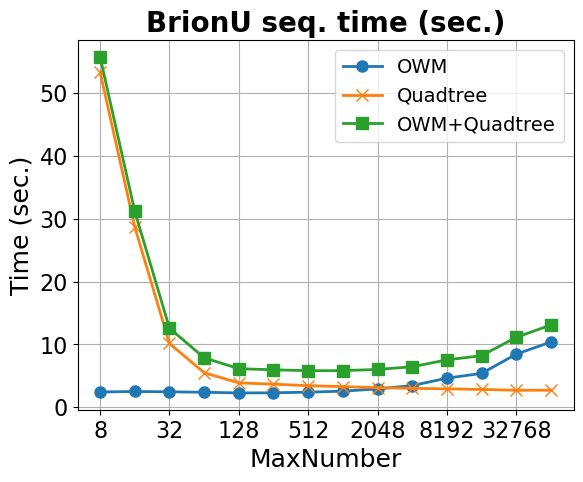

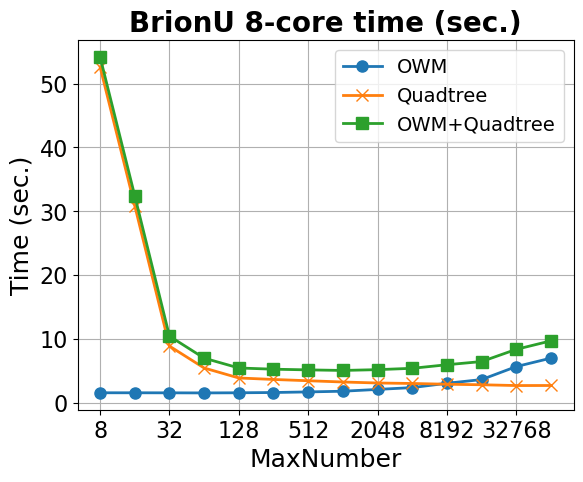

In [17]:
import matplotlib.pyplot as plt
def plot_cloudtime(cloudname,nth,results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    x=list(results[cloudname].keys())
    fig = plt.figure()
    xticks=range(1,len(x)+1)

    plt.plot(np.array(xticks), np.array([results[cloudname][i][nth]['owm'] for i in x]), marks[0], linewidth=linew, markersize=markers)
    plt.plot(np.array(xticks), np.array([results[cloudname][i][nth]['qtree'] for i in x]), marks[1], linewidth=linew, markersize=markers)
    plt.plot(np.array(xticks), np.array([results[cloudname][i][nth]['qtree']+results[cloudname][i][nth]['owm'] for i in x]), marks[2], linewidth=linew, markersize=markers)

    labels=['OWM','Quadtree','OWM+Quadtree']
    if nth==1:
        plt.title(cloudname+' seq. time (sec.)',  fontweight='bold', fontsize=titlefs)
    else:
        plt.title(cloudname+' 8-core time (sec.)',  fontweight='bold', fontsize=titlefs)
    plt.legend(labels,loc='best', fontsize= legendfs)
    plt.ylabel('Time (sec.)', fontsize=ylabelfs)
    plt.xlabel('MaxNumber', fontsize=xlabelfs)

    plt.xticks(ticks=xticks[::2], labels=x[::2], fontsize=xticksfs)
    plt.yticks(fontsize=yticksfs)
    plt.grid()

    plt.show()

plot_cloudtime('Alcoy',1,res1)
plot_cloudtime('Alcoy',8,res1)
plot_cloudtime('Arzua',1,res1)
plot_cloudtime('Arzua',8,res1)
plot_cloudtime('BrionF',1,res1)
plot_cloudtime('BrionF',8,res1)
plot_cloudtime('BrionU',1,res1)
plot_cloudtime('BrionU',8,res1)

In [49]:

pp = PdfPages("Speedup-qmin.pdf")
pp.savefig(fig)
pp.close()